In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 15.2 MB/s eta 0:00:00


In [3]:
df = pd.read_csv("/content/lasalgaon_onion_features.csv", parse_dates=["Arrival_Date"])
df = df.sort_values("Arrival_Date").reset_index(drop=True)

df.head()

,Arrival_Date,festival_window,Modal_Price,log_ret,vol_7,vol_30,month,week,day_of_week,precip_mm,rainfall_7d,days_since_last_arrival,is_price_jump
0,2013-01-10,0,1220.0,0.000000,0.051018,0.095999,1,2,3,0.0,0.0,1.0,0
1,2013-01-14,0,1225.0,0.004090,0.048343,0.095999,1,3,0,0.0,0.0,4.0,0
2,2013-01-15,0,1225.0,0.000000,0.048313,0.095999,1,3,1,0.0,0.0,1.0,0
3,2013-01-16,0,1260.0,0.028171,0.042345,0.095999,1,3,2,0.0,0.0,1.0,0
4,2013-01-17,0,1390.0,0.098192,0.039092,0.095999,1,3,3,0.0,0.0,1.0,0


In [4]:
df['vol_7_next'] = df['vol_7'].shift(-1)
df['year'] = df['Arrival_Date'].dt.year

def yearly_bins(s):
    q1 = s.quantile(0.33)
    q2 = s.quantile(0.66)
    return pd.cut(s, [-np.inf, q1, q2, np.inf], labels=[0,1,2])

df['vol_class_next'] = df.groupby("year")['vol_7_next'].transform(yearly_bins)
df = df.dropna(subset=['vol_class_next'])
df['vol_class_next'] = df['vol_class_next'].astype(int)

print(df['vol_class_next'].value_counts(normalize=True))


vol_class_next
2    0.340341
0    0.330192
1    0.329467
Name: proportion, dtype: float64


In [5]:
#Lag features
df['log_return_lag1'] = df['log_ret'].shift(1)
df['vol_7_lag1'] = df['vol_7'].shift(1)
df['vol_30_lag1'] = df['vol_30'].shift(1)
df['rainfall_7d_lag1'] = df['rainfall_7d'].shift(1)

#Price momentum
df["price_momentum_7"] = df["log_ret"].rolling(window=7, min_periods=1).sum().fillna(0.0)
df["price_momentum_3"] = df["log_ret"].rolling(window=3, min_periods=1).sum().fillna(0.0)


In [6]:
# 3. Cyclical encoding
df['month_sin'] = np.sin(2*np.pi*(df['month']-1)/12)
df['month_cos'] = np.cos(2*np.pi*(df['month']-1)/12)
df['dow_sin'] = np.sin(2*np.pi*df['day_of_week']/7)
df['dow_cos'] = np.cos(2*np.pi*df['day_of_week']/7)

df = df.dropna()
df.head()

,Arrival_Date,festival_window,Modal_Price,log_ret,vol_7,vol_30,month,week,day_of_week,precip_mm,...,log_return_lag1,vol_7_lag1,vol_30_lag1,rainfall_7d_lag1,price_momentum_7,price_momentum_3,month_sin,month_cos,dow_sin,dow_cos
1,2013-01-14,0,1225.0,0.004090,0.048343,0.095999,1,3,0,0.0,...,0.000000,0.051018,0.095999,0.0,0.004090,0.004090,0.0,1.0,0.000000,1.000000
2,2013-01-15,0,1225.0,0.000000,0.048313,0.095999,1,3,1,0.0,...,0.004090,0.048343,0.095999,0.0,0.004090,0.004090,0.0,1.0,0.781831,0.623490
3,2013-01-16,0,1260.0,0.028171,0.042345,0.095999,1,3,2,0.0,...,0.000000,0.048313,0.095999,0.0,0.032261,0.032261,0.0,1.0,0.974928,-0.222521
4,2013-01-17,0,1390.0,0.098192,0.039092,0.095999,1,3,3,0.0,...,0.028171,0.042345,0.095999,0.0,0.130453,0.126363,0.0,1.0,0.433884,-0.900969
5,2013-01-18,0,1500.0,0.076161,0.044896,0.095999,1,3,4,0.0,...,0.098192,0.039092,0.095999,0.0,0.206614,0.202524,0.0,1.0,-0.433884,-0.900969


In [7]:
df.columns

Index(['Arrival_Date', 'festival_window', 'Modal_Price', 'log_ret', 'vol_7',
       'vol_30', 'month', 'week', 'day_of_week', 'precip_mm', 'rainfall_7d',
       'days_since_last_arrival', 'is_price_jump', 'vol_7_next', 'year',
       'vol_class_next', 'log_return_lag1', 'vol_7_lag1', 'vol_30_lag1',
       'rainfall_7d_lag1', 'price_momentum_7', 'price_momentum_3', 'month_sin',
       'month_cos', 'dow_sin', 'dow_cos'],
      dtype='object')

In [8]:
from datetime import timedelta

govt=pd.read_csv('/content/onion_government_interventions_lasalgaon_2013_2025.csv',parse_dates=['Date'])

/tmp/ipython-input-4141692475.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  govt=pd.read_csv('/content/onion_government_interventions_lasalgaon_2013_2025.csv',parse_dates=['Date'])


In [9]:
rows=[]
for _,r in govt.iterrows():
  for d in pd.date_range(r['Date']-timedelta(days=3),r['Date']+timedelta(days=3)):
    rows.append({'date':d,'policy_type':r['Category'],'govt_window':1})
govt_window=pd.DataFrame(rows).drop_duplicates()

In [10]:
df=df.merge(govt_window.rename(columns={'date':'Arrival_Date'}),on='Arrival_Date',how='left')
df['govt_window']=df['govt_window'].fillna(0).astype(int)
df['policy_type']=df['policy_type'].fillna('none')

In [11]:
df['policy_type'].value_counts()

,count
policy_type,
none,2531
Export Restriction - MEP,61
Buffer Stock,36
Policy Liberalization,26
Buffer Stock Release,25
Stock Limit,20
Export Ban,14
State Relief,9
Market Intervention,6


In [12]:
mapping = {
    # export-related
    'Export Restriction - MEP':       'export_restriction',
    'Export Ban':                     'export_restriction',
    'Export Ban Extension':           'export_restriction',
    'Export Duty':                    'export_restriction',
    'Export Policy':                  'export_restriction',

    # buffer operations
    'Buffer Stock':                   'buffer_operations',
    'Buffer Stock Release':           'buffer_operations',

    # stock limit
    'Stock Limit':                    'stock_limit_actions',
    'Stock Limit Revision':           'stock_limit_actions',

    # import support
    'Import Action':                  'import_support',
    'Import Facilitation':            'import_support',

    # market intervention / relief
    'Market Monitoring':              'market_intervention',
    'Market Intervention':            'market_intervention',
    'Market Relief':                  'market_intervention',
    'Retail Sales Intervention':      'market_intervention',

    # farmer-related disruptions
    'Farmer Action':                  'farmer_actions',
    'Farmer Protest':                 'farmer_actions',

    # procurement & relief
    'Procurement Request':            'procurement_support',
    'State Relief':                   'procurement_support',
    'Policy Liberalization':          'procurement_support',
}


In [13]:
df['policy_group'] = df['policy_type'].map(mapping).fillna('none')
df = pd.get_dummies(df, columns=['policy_group'], prefix='govt', dummy_na=False)

In [14]:
features = [
    'log_ret', 'log_return_lag1',
    'vol_7', 'vol_7_lag1',
    'vol_30', 'vol_30_lag1',
    'rainfall_7d', 'rainfall_7d_lag1',
    'festival_window',
    'days_since_last_arrival',
    'is_price_jump',
    'price_momentum_7', 'price_momentum_3',
    'month_sin','month_cos','dow_sin','dow_cos'
]

govt_features=[c for c in df.columns if c.startswith('govt_')]
features+=govt_features

In [15]:
features

['log_ret',
 'log_return_lag1',
 'vol_7',
 'vol_7_lag1',
 'vol_30',
 'vol_30_lag1',
 'rainfall_7d',
 'rainfall_7d_lag1',
 'festival_window',
 'days_since_last_arrival',
 'is_price_jump',
 'price_momentum_7',
 'price_momentum_3',
 'month_sin',
 'month_cos',
 'dow_sin',
 'dow_cos',
 'govt_window',
 'govt_buffer_operations',
 'govt_export_restriction',
 'govt_farmer_actions',
 'govt_import_support',
 'govt_market_intervention',
 'govt_none',
 'govt_procurement_support',
 'govt_stock_limit_actions']

In [105]:
import optuna, xgboost as xgb, joblib, numpy as np, pandas as pd
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from datetime import datetime

# ---------------- SETTINGS ----------------
N_TRIALS = 60
N_SPLITS = 3
SEED = 42
NUM_BOOST_ROUND = 500
EARLY_STOP = 30
NTHREAD = 4
SQLITE_DB = "sqlite:///optuna_fast.db"  # persistent study storage so you can resume

# ---------- prepare data ----------
df = df.sort_values("Arrival_Date").reset_index(drop=True)
X_all = df[features].fillna(0).values
y_all = df['vol_class_next'].values

tscv = TimeSeriesSplit(n_splits=N_SPLITS)

# ---------- objective ----------
def objective(trial):
    params = {
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "verbosity": 0,
        "seed": SEED,
        "nthread": NTHREAD,
        # tuned hyperparams
        "eta": trial.suggest_float("eta", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 3.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 3.0),
        "gamma": trial.suggest_float("gamma", 0.0, 3.0),
    }

    accs = []
    for train_idx, val_idx in tscv.split(X_all):
        X_tr, X_val = X_all[train_idx], X_all[val_idx]
        y_tr, y_val = y_all[train_idx], y_all[val_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)

        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(dval, "valid")],
            callbacks=[xgb.callback.EarlyStopping(rounds=EARLY_STOP, save_best=True)],
        )

        preds = np.argmax(bst.predict(dval), axis=1)
        accs.append(accuracy_score(y_val, preds))

    return float(np.mean(accs))

# ---------- run study (persistent) ----------
sampler = TPESampler(seed=SEED)
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=5)

study = optuna.create_study(study_name="fast_opt", direction="maximize", sampler=sampler, pruner=pruner, storage=SQLITE_DB, load_if_exists=True)
print(f"Starting Optuna: {N_TRIALS} trials, splits={N_SPLITS}, seed={SEED}, db={SQLITE_DB}")
start = datetime.now()
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
end = datetime.now()
print(f"Finished Optuna — duration: {end - start}")

print("\nBest trial:")
print("  CV acc:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print("   ", k, ":", v)

# ---------- train final booster using best params ----------
best_params = study.best_params
best_params.update({"objective":"multi:softprob","num_class":3,"eval_metric":"mlogloss","tree_method":"hist","verbosity":0,"seed":SEED, "nthread": NTHREAD})

# use final small holdout (last fold) to get best iteration then train final on all data
splits = list(tscv.split(X_all))
last_train_idx, last_val_idx = splits[-1]
dtrain_hold = xgb.DMatrix(X_all[last_train_idx], label=y_all[last_train_idx])
dval_hold = xgb.DMatrix(X_all[last_val_idx], label=y_all[last_val_idx])

bst_temp = xgb.train(best_params, dtrain_hold, num_boost_round=NUM_BOOST_ROUND,
                     evals=[(dval_hold,'valid')],
                     callbacks=[xgb.callback.EarlyStopping(rounds=EARLY_STOP, save_best=True)])
best_iter = getattr(bst_temp, "best_iteration", None)
if best_iter is None:
    best_iter = int(NUM_BOOST_ROUND / 2)

print("Best iteration from holdout:", best_iter)

dall = xgb.DMatrix(X_all, label=y_all)
final_bst = xgb.train(best_params, dall, num_boost_round=best_iter)
final_model_path = "xgb_final_opt_fast.model"
final_bst.save_model(final_model_path)
print("Saved final model:", final_model_path)

# save study
joblib.dump(study, "optuna_study_fast.pkl")
print("Saved Optuna study -> optuna_study_fast.pkl")


[I 2025-11-26 08:18:40,249] Using an existing study with name 'fast_opt' instead of creating a new one.


Starting Optuna: 60 trials, splits=3, seed=42, db=sqlite:///optuna_fast.db


  0%|          | 0/60 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[52]	valid-mlogloss:0.64567
[53]	valid-mlogloss:0.64529
[54]	valid-mlogloss:0.64530
[55]	valid-mlogloss:0.64565
[56]	valid-mlogloss:0.64547
[57]	valid-mlogloss:0.64556
[58]	valid-mlogloss:0.64597
[59]	valid-mlogloss:0.64583
[60]	valid-mlogloss:0.64584
[61]	valid-mlogloss:0.64604
[62]	valid-mlogloss:0.64596
[63]	valid-mlogloss:0.64520
[64]	valid-mlogloss:0.64522
[65]	valid-mlogloss:0.64564
[66]	valid-mlogloss:0.64573
[67]	valid-mlogloss:0.64567
[68]	valid-mlogloss:0.64595
[69]	valid-mlogloss:0.64616
[70]	valid-mlogloss:0.64595
[71]	valid-mlogloss:0.64545
[72]	valid-mlogloss:0.64588
[73]	valid-mlogloss:0.64566
[74]	valid-mlogloss:0.64578
[75]	valid-mlogloss:0.64490
[76]	valid-mlogloss:0.64498
[77]	valid-mlogloss:0.64538
[78]	valid-mlogloss:0.64564
[79]	valid-mlogloss:0.64670
[80]	valid-mlogloss:0.64667
[81]	valid-mlogloss:0.64636
[82]	valid-mlogloss:0.64643
[83]	valid-mlogloss:0.64649
[84]	valid-mlogloss:0.64647
[85]	valid-mlogloss:0.646

In [109]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


final_bst = xgb.Booster()
final_bst.load_model("xgb_final_opt_fast.model")

print("Model loaded.")

df = df.sort_values("Arrival_Date").reset_index(drop=True)
y_all = df["vol_class_next"].astype(int).values
X_all = df[features].fillna(0).values

Model loaded.


In [16]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


final_bst = xgb.Booster()
final_bst.load_model("xgb_final_opt_fast.model")

print("Model loaded.")

df = df.sort_values("Arrival_Date").reset_index(drop=True)
y_all = df["vol_class_next"].astype(int).values
X_all = df[features].fillna(0).values

Model loaded.


/tmp/ipython-input-3268116559.py:8: UserWarning: [13:03:56] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  final_bst.load_model("xgb_final_opt_fast.model")


In [43]:
mask_2017_2023=(df["Arrival_Date"].dt.year<=2023) & (df["Arrival_Date"].dt.year>=2017)

In [44]:
q1=df.loc[mask_2017_2023,'vol_7_next'].quantile(0.33)
q2=df.loc[mask_2017_2023,'vol_7_next'].quantile(0.66)
print("Q1",q1)
print("Q2",q2)

Q1 0.05486396524554374
Q2 0.09468032867386889


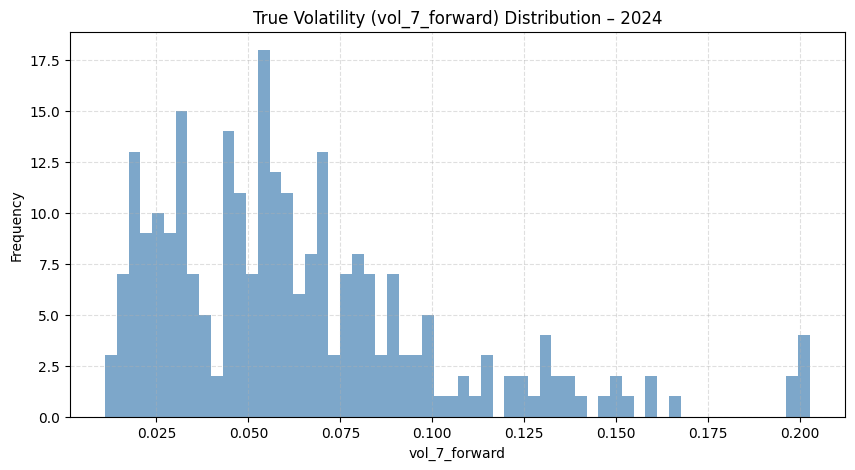

In [37]:
import matplotlib.pyplot as plt

df_train = df[df['Arrival_Date'].dt.year== 2024]


plt.figure(figsize=(10,5))
plt.hist(df_train['vol_7_next'], bins=60, alpha=0.7, color='steelblue')
plt.title("True Volatility (vol_7_forward) Distribution – 2024")
plt.xlabel("vol_7_forward")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

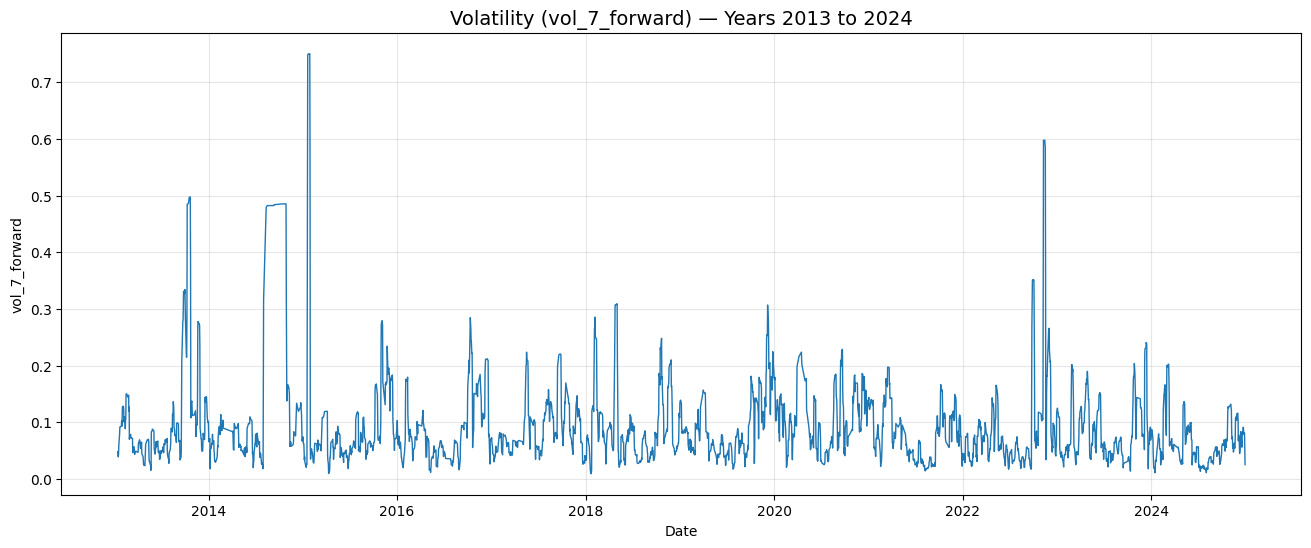

In [40]:
df_plot = df[(df.Arrival_Date.dt.year >= 2013) &
             (df.Arrival_Date.dt.year <= 2024)].copy()


plt.figure(figsize=(16,6))
plt.plot(df_plot['Arrival_Date'], df_plot['vol_7_next'], linewidth=1)
plt.title("Volatility (vol_7_forward) — Years 2013 to 2024", fontsize=14)
plt.xlabel("Date")
plt.ylabel("vol_7_forward")
plt.grid(True, alpha=0.3)
plt.show()

In [45]:
def classify_global(vol, q1, q2):
    if vol < q1:
        return 0     # Low
    elif vol < q2:
        return 1     # Medium
    else:
        return 2     # High

In [46]:
df_2024 = df[df['Arrival_Date'].dt.year == 2024].copy()
df_2024['vol_class_next_global'] = df_2024['vol_7_next'].apply(lambda x: classify_global(x, q1, q2))

In [47]:
X_2024 = df_2024[features].fillna(0).values
y_2024 = df_2024["vol_class_next_global"].astype(int).values


dval = xgb.DMatrix(X_2024)
pred_2024 = np.argmax(final_bst.predict(dval), axis=1)
proba_2024=final_bst.predict(dval)


print("Accuracy 2024:", accuracy_score(y_2024, pred_2024))
print("\nClassification Report:\n", classification_report(y_2024, pred_2024, digits=4))

Accuracy 2024: 0.7662835249042146

Classification Report:
               precision    recall  f1-score   support

           0     0.9238    0.7951    0.8546       122
           1     0.6957    0.6667    0.6809        96
           2     0.6094    0.9070    0.7290        43

    accuracy                         0.7663       261
   macro avg     0.7429    0.7896    0.7548       261
weighted avg     0.7881    0.7663    0.7700       261



In [49]:
cm = confusion_matrix(y_2024, pred_2024, labels=[0,1,2])
cm_df = pd.DataFrame(
    cm,
    index=['True Low (0)','True Med (1)','True High (2)'],
    columns=['Pred Low (0)','Pred Med (1)','Pred High (2)']
)
print("\nConfusion Matrix:\n", cm_df)


Confusion Matrix:
                Pred Low (0)  Pred Med (1)  Pred High (2)
True Low (0)             97            25              0
True Med (1)              7            64             25
True High (2)             1             3             39


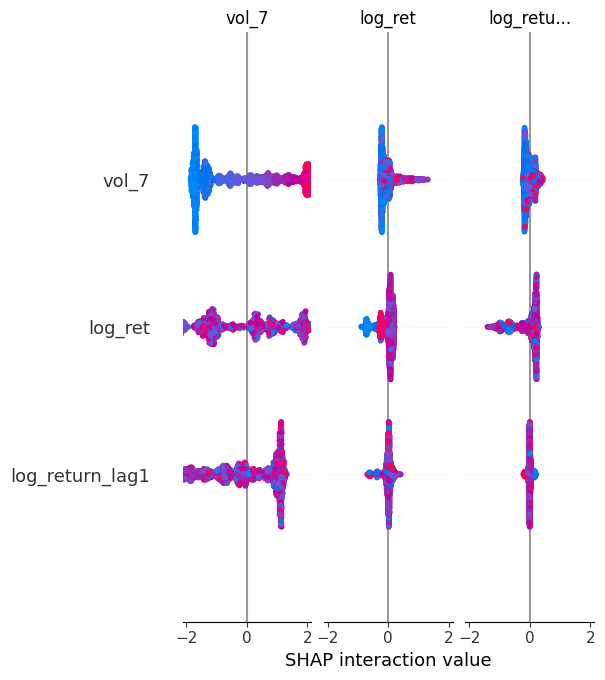

In [33]:
import shap
explainer = shap.TreeExplainer(final_bst)
shap_values = explainer.shap_values(X_all)

shap.summary_plot(shap_values, X_all, feature_names=features)

In [117]:
# ============================================
# FINAL MODEL RETRAINING ON ALL DATA (2013–2024)
# USING BEST PARAMS + BEST ITER FROM OPTUNA
# ============================================

import xgboost as xgb
import numpy as np
import json

df = df.sort_values("Arrival_Date").reset_index(drop=True)
X_all = df[features].fillna(0).values
y_all = df["vol_class_next"].astype(int).values
dall = xgb.DMatrix(X_all, label=y_all)

best_params = study.best_params.copy()    # from Optuna
best_params.update({
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "tree_method": "hist",
    "verbosity": 0,
    "seed": 42,
    "nthread": 4,
})

print("Best Params from Optuna:", best_params)
print("Using best_iter =", best_iter)


final_bst = xgb.train(
    params=best_params,
    dtrain=dall,
    num_boost_round=int(best_iter)
)

final_model_path = "xgb_final_all_data.model"
final_bst.save_model(final_model_path)


print(" FINAL MODEL SAVED SUCCESSFULLY ")
print(" File:", final_model_path)


metadata = {
    "features": features,
    "best_params": best_params,
    "best_iter": int(best_iter),
    "optuna_best_value": float(study.best_value)
}


with open("model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("Saved model_metadata.json")


Best Params from Optuna: {'eta': 0.0974351877648229, 'max_depth': 3, 'subsample': 0.633714280569533, 'colsample_bytree': 0.6402810919327134, 'min_child_weight': 10, 'reg_alpha': 0.3068092010700414, 'reg_lambda': 0.42051944618721815, 'gamma': 1.6061347992900015, 'objective': 'multi:softprob', 'num_class': 3, 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'verbosity': 0, 'seed': 42, 'nthread': 4}
Using best_iter = 129
 FINAL MODEL SAVED SUCCESSFULLY 
 File: xgb_final_all_data.model
Saved model_metadata.json


In [59]:
mask_2017_2024=(df["Arrival_Date"].dt.year<=2024) & (df["Arrival_Date"].dt.year>=2017)

In [60]:
q1=df.loc[mask_2017_2024,'vol_7_next'].quantile(0.33)
q2=df.loc[mask_2017_2024,'vol_7_next'].quantile(0.66)
print("Q1",q1)
print("Q2",q2)

Q1 0.05316398313903646
Q2 0.08882703501291653


In [61]:
import xgboost as xgb
import numpy as np
import pandas as pd
from statistics import median


MODEL_PATH = "xgb_final_all_data.model"
TRAIN_START_YEAR = 2017
TRAIN_END_YEAR   = 2024
FEATURE_COLS_NAME = "features"  # name of your features variable in notebook; if you use 'features' list, keep as-is


df['Arrival_Date'] = pd.to_datetime(df['Arrival_Date']).dt.normalize()

vol_col = "vol_7_next"

mask_train = (df['Arrival_Date'].dt.year >= TRAIN_START_YEAR) & (df['Arrival_Date'].dt.year <= TRAIN_END_YEAR)

df_train=df.loc[mask_train]
q1 = df_train[vol_col].quantile(0.33)
q2 = df_train[vol_col].quantile(0.66)
print(f"Volatility quantiles on training data: Q1={q1:.6f}, Q2={q2:.6f}")



def vol_to_class(v, q1=q1, q2=q2):
    if pd.isna(v):
        return np.nan
    if v < q1:
        return 0
    if v < q2:
        return 1
    return 2


df_train['vol_class_true'] = df_train[vol_col].apply(lambda v: vol_to_class(v))


df_train = df_train.dropna(subset=['vol_class_true']).reset_index(drop=True)
df_train['vol_class_true'] = df_train['vol_class_true'].astype(int)


bst = xgb.Booster()
bst.load_model(MODEL_PATH)
print("Model loaded from", MODEL_PATH)

X_train = df_train[features].fillna(0.0)


dmat = xgb.DMatrix(X_train.values, feature_names=list(X_train.columns))
proba = bst.predict(dmat)


proba = np.array(proba)

cvi_scores = (proba[:,1] * 50.0) + (proba[:,2] * 100.0)
df_train['cvi_score'] = cvi_scores


median_low  = df_train.loc[df_train['vol_class_true']==0, 'cvi_score'].median()
median_med  = df_train.loc[df_train['vol_class_true']==1, 'cvi_score'].median()
median_high = df_train.loc[df_train['vol_class_true']==2, 'cvi_score'].median()


print("Median CVI per true class (train):")
print(" Low  (true class 0) ->", median_low)
print(" Med  (true class 1) ->", median_med)
print(" High (true class 2) ->", median_high)



# Use medians as separators (low_med = midpoint of Low & Med medians; med_high = midpoint of Med & High medians)
low_med_threshold  = float((median_low + median_med) / 2.0)
med_high_threshold = float((median_med + median_high) / 2.0)


print("\nDerived CVI score thresholds (Option A — midpoints):")
print(" low -> medium  :", low_med_threshold)
print(" medium -> high :", med_high_threshold)


# helper function to label any CVI score consistently
def cvi_label_from_score(score, low_med=low_med_threshold, med_high=med_high_threshold):
    if score < low_med:
        return "Low"
    if score < med_high:
        return "Medium"
    return "High"


# attach labels to train
df_train['cvi_label_from_score'] = df_train['cvi_score'].apply(lambda s: cvi_label_from_score(s))


# show small summary counts
print("\nCounts by true vol class vs CVI label (train slice):")
print(pd.crosstab(df_train['vol_class_true'].map({0:'True Low',1:'True Med',2:'True High'}),
                  df_train['cvi_label_from_score']))


thresholds = {"low_med_score": low_med_threshold, "med_high_score": med_high_threshold}
print("\nFINAL THRESHOLDS ", thresholds)


Volatility quantiles on training data: Q1=0.053164, Q2=0.088827
Model loaded from xgb_final_all_data.model
Median CVI per true class (train):
 Low  (true class 0) -> 6.868401050567627
 Med  (true class 1) -> 50.089115142822266
 High (true class 2) -> 92.92666625976562

Derived CVI score thresholds (Option A — midpoints):
 low -> medium  : 28.478758096694946
 medium -> high : 71.50789070129395

Counts by true vol class vs CVI label (train slice):
cvi_label_from_score  High  Low  Medium
vol_class_true                         
True High              588    7      70
True Low                 8  551      87
True Med                79   76     490

FINAL THRESHOLDS  {'low_med_score': 28.478758096694946, 'med_high_score': 71.50789070129395}


/tmp/ipython-input-2920334622.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['vol_class_true'] = df_train[vol_col].apply(lambda v: vol_to_class(v))
/tmp/ipython-input-2920334622.py:44: UserWarning: [14:45:47] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  bst.load_model(MODEL_PATH)
